In [79]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
df = pd.read_csv('../input/voicegender/voice.csv')
df.columns

Index(['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt',
       'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'label'],
      dtype='object')

In [81]:
df.shape

(3168, 21)

In [82]:
df.dtypes

meanfreq    float64
sd          float64
median      float64
Q25         float64
Q75         float64
IQR         float64
skew        float64
kurt        float64
sp.ent      float64
sfm         float64
mode        float64
centroid    float64
meanfun     float64
minfun      float64
maxfun      float64
meandom     float64
mindom      float64
maxdom      float64
dfrange     float64
modindx     float64
label        object
dtype: object

In [83]:
df.head(3)

meanfreq        sd    median       Q25       Q75       IQR       skew  \
0  0.059781  0.064241  0.032027  0.015071  0.090193  0.075122  12.863462   
1  0.066009  0.067310  0.040229  0.019414  0.092666  0.073252  22.423285   
2  0.077316  0.083829  0.036718  0.008701  0.131908  0.123207  30.757155   

          kurt    sp.ent       sfm  ...  centroid   meanfun    minfun  \
0   274.402906  0.893369  0.491918  ...  0.059781  0.084279  0.015702   
1   634.613855  0.892193  0.513724  ...  0.066009  0.107937  0.015826   
2  1024.927705  0.846389  0.478905  ...  0.077316  0.098706  0.015656   

     maxfun   meandom    mindom    maxdom   dfrange   modindx  label  
0  0.275862  0.007812  0.007812  0.007812  0.000000  0.000000   male  
1  0.250000  0.009014  0.007812  0.054688  0.046875  0.052632   male  
2  0.271186  0.007990  0.007812  0.015625  0.007812  0.046512   male  

[3 rows x 21 columns]

In [84]:
df.isnull().values.any()

False

male      1584
female    1584
Name: label, dtype: int64


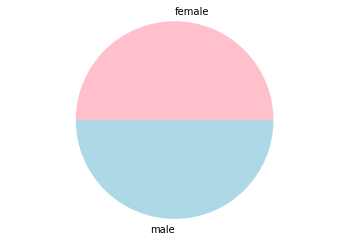

In [85]:
# Distribution of target varibles
colors = ['pink','Lightblue']
data_y = df[df.columns[-1]]
plt.pie(data_y.value_counts(),colors=colors,labels=['female','male'])
plt.axis('equal')
print (df['label'].value_counts())

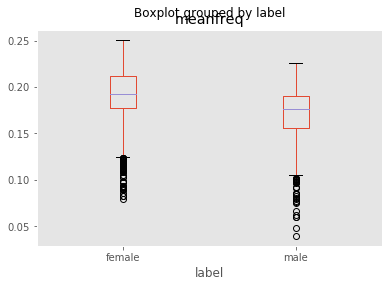

In [86]:
# Box plot see comparision in labels by other features
df.boxplot(column = 'meanfreq',by='label',grid=False)

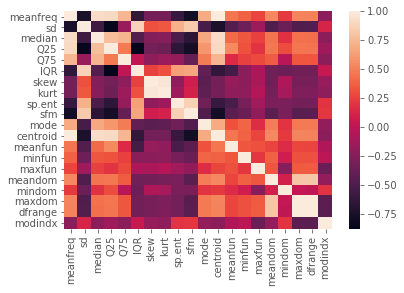

In [87]:
# plot correlation matrix (here i used the headmape using seaborn)
correlation =df.corr()
sns.heatmap(correlation)
plt.show()

# Machine learning part:


In [88]:
# train_test_split is responsible to split the data into (Train and Test)
from sklearn.model_selection import train_test_split
X = df[df.columns[:-1]].values
#y = df['lable']
y = df[df.columns[-1]].values
# We will divide the data into 70-30% into train and test data
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.30)

In [89]:
import warnings
warnings.filterwarnings("ignore")
# Random forest
# Importing Random forest Classifier
from sklearn.ensemble import RandomForestClassifier
rand_forest = RandomForestClassifier()
rand_forest.fit(Xtrain, ytrain)
y_pred = rand_forest.predict(Xtest)


In [90]:
#import matrix to calcualte accuracy
from sklearn import metrics, neighbors
from sklearn.metrics import accuracy_score
print(metrics.accuracy_score(ytest, y_pred))

0.9810725552050473


In [91]:
# Import confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, y_pred))

[[444   9]
 [  9 489]]


In [92]:
# 10-fold cross validation
# Importing Bausian Classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
CVFirst = GaussianNB()
CVFirst = CVFirst.fit(Xtrain, ytrain)
test_result = cross_val_score(CVFirst, X, y, cv=10, scoring='accuracy')
print('Accuracy obtained from 10-fold cross validation is:',test_result.mean())

Accuracy obtained from 10-fold cross validation is: 0.8563410933194906


# Data cleaning

 Exceptable range of voice freq for a human as per will is betwwen 0.085
and 0.255KHz and hence we will identify the variable which has the frequency
information and remove them assuming it to be a outlier based on domain knowledge.
As per the station given in wiki we can say that typical adult male will
have a fundamental frequency from 85 to 189 Hz and typical adult female from 165 to 255 Hz.

In [93]:
male_funFreq_outlier_index = df[((df['meanfun'] < 0.085) | (df['meanfun'] > 0.180)) &
                               (df['label'] == 'male')].index
female_funFreq_outlier_index = df[((df['meanfun'] < 0.165)  | (df['meanfun'] > 0.255)) &
                                 (df['label'] == 'female')].index

In [94]:
index_to_remove = list(male_funFreq_outlier_index) + list(female_funFreq_outlier_index)
len(index_to_remove)

710

In [95]:
data_x = df[df.columns[0:20]].copy()
data2 = data_x.drop(['kurt','centroid','dfrange'],axis=1).copy()
data2.head(3)
data2 = data2.drop(index_to_remove,axis=0)

#y = df['lable']
data_y = pd.Series(y).drop(index_to_remove,axis=0)
Xtrain, Xtest, ytrain, ytest = train_test_split(data2, data_y, test_size=0.30 )
clf1 = RandomForestClassifier()
clf1.fit(Xtrain, ytrain)
y_pred = clf1.predict(Xtest)
print(metrics.accuracy_score(ytest, y_pred))

0.9986449864498645


In [96]:
# Importing Decision Trees Classifier
from sklearn.tree import DecisionTreeClassifier
clf2 = DecisionTreeClassifier()
clf2.fit(Xtrain, ytrain)
y_predict = clf2.predict(Xtest)
print(metrics.accuracy_score(ytest, y_predict))

0.9959349593495935


In [97]:
clf3 = GaussianNB()
clf3 = clf3.fit(Xtrain, ytrain)
y_predd = clf3.predict(Xtest)
print(metrics.accuracy_score(ytest,y_predd))

0.975609756097561


In [98]:
# Importing linear Regression classifier
from sklearn.linear_model import LogisticRegression
clf4 = LogisticRegression()
clf4.fit(Xtrain,ytrain)
y_predict4 = clf4.predict(Xtest)
print(metrics.accuracy_score(ytest,y_predict4))

0.8997289972899729


In [99]:
# cross validation with same classifire as first time 
test_result = cross_val_score(clf3, data2, data_y, cv=10, scoring='accuracy')
print('Accuracy obtained from 10-flod cross validation is:',test_result.mean())

Accuracy obtained from 10-flod cross validation is: 0.9637979094076655


In [100]:
# cros validation on the best result
test_result = cross_val_score(clf2, data2, data_y, cv=10,scoring = 'accuracy')
print('Accuracy obtained from 10-fold validation is:',test_result.mean())

Accuracy obtained from 10-fold validation is: 0.9902356064376969


# Confusion matrix

[[306   0]
 [  1 431]]


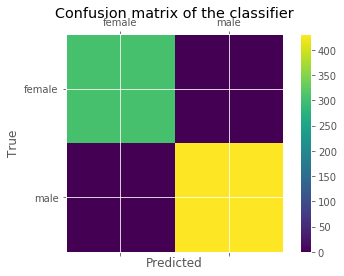

In [101]:
import pylab as pl
labels = ['female', 'male']
cm = confusion_matrix(ytest,y_pred,labels)  #ypred for RandomForest
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax =ax.matshow(cm)
pl.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
pl.xlabel('Predicted')
pl.ylabel('True')
pl.show()

In [102]:
from sklearn.metrics import classification_report
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

      female       1.00      1.00      1.00       306
        male       1.00      1.00      1.00       432

    accuracy                           1.00       738
   macro avg       1.00      1.00      1.00       738
weighted avg       1.00      1.00      1.00       738



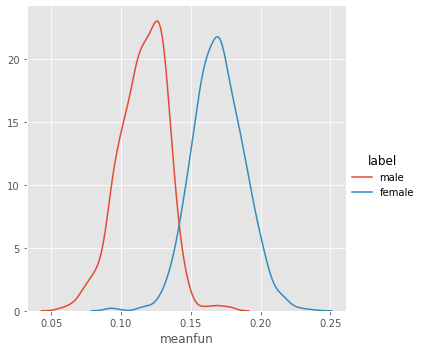

In [103]:
# Distribution of male and female
sns.FacetGrid(df, hue='label',size=5).map(sns.kdeplot,"meanfun").add_legend()
plt.show()

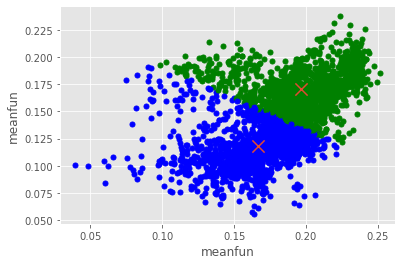

In [104]:
#Since we're doing flat-clustering , our task is a bit easier since we can tell the machine that we want it category

from sklearn.cluster import KMeans
from matplotlib import style
style.use("ggplot")

data_x = np.array(df[['meanfreq','meanfun']])
kmeans = KMeans(n_clusters= 2)
kmeans.fit(data_x)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

#print(centroids)
#print(labels) # 0-male, 1-Female( the machine has assigned on its own.)

colors = ["g.","b."]  #green = male

for i in range(len(data_x)):
    plt.plot(data_x[i][0], data_x[i][1], colors[labels[i]], markersize = 10)

    
plt.scatter(centroids[:,0],centroids[:, 1], marker = "x", s=150, linewidths = 5, zorder = 10)
plt.ylabel('meanfun')
plt.xlabel('meanfun')

plt.show()